In [2]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
enss=['b','c','d']
ens2RCs={ens:{} for ens in enss}

path='data_aux/paperRenorms.txt'
with open(path,'r') as f:
    rcs=f.read().splitlines()

Zs=['Zqq(mu=nu)','Zqq(mu!=nu)','Zqq^s(mu=nu)','Zqq^s(mu!=nu)','Zqg(mu!=nu)','Zgq(mu=nu)','Zgq(mu!=nu)']
for iZ,Z in enumerate(Zs):
    for iens,ens in enumerate(enss):
        t=rcs[iZ*4+iens]
        if '(' not in t:
            ens2RCs[ens][Z] = float(t)
            ens2RCs[ens][Z+'_err'] = 0
        else:
            ind_dot=t.find('.')
            ind_b=t.find('(')
            ind_k=t.find(')')
            ens2RCs[ens][Z] = float(t[:ind_b])
            ens2RCs[ens][Z+'_err'] = float(t[ind_b+1:ind_k]) * 10**(-(ind_b-ind_dot)+1)

for ens,ensL in zip(enss,['cB64','cC80','cD96']):
    path=f'data_aux/Zgg_c{ens.upper()}4.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        for i,row in enumerate(t):
            # if i==0:
            #     continue
            nstout,mean,err=[float(ele) for ele in row.split('\t')]
            nstout=int(nstout)
            assert(nstout==i)
            ens2RCs[ens][f'Zgg^{i}(mu!=nu)']=mean
            ens2RCs[ens][f'Zgg^{i}(mu!=nu)_err']=err
            
# Fake ones
# for ens in enss:
#     for z in ['Zqg'] + [f'Zgg^{i}' for i in range(0,40)]:
#         ens2RCs[ens][f'{z}(mu=nu)']=ens2RCs[ens][f'{z}(mu!=nu)']*0.9
#         ens2RCs[ens][f'{z}(mu=nu)_err']=ens2RCs[ens][f'{z}(mu=nu)']*0.1    
            
for ens in enss:
    path=f'data_aux/RCs_Gregoris/Zgg_mu_eq_nu_c{ens.upper()}4.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        for i,row in enumerate(t):
            # if i==0:
            #     continue
            nstout,mean,err=[float(ele) for ele in row.split('\t')]
            nstout=int(nstout)
            assert(nstout==i)
            ens2RCs[ens][f'Zgg^{i}(mu=nu)']=mean
            ens2RCs[ens][f'Zgg^{i}(mu=nu)_err']=err
            
for ens in enss:
    path=f'data_aux/RCs_Gregoris/Zqq_Zqg_Zgq_mu_eq_nu_c{ens.upper()}4.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        for i,row in enumerate(t):
            key,val=row.replace(" ", "").split('=')
            if '(' not in val:
                mean=float(val); err=0
            else:
                ind_dot=val.find('.')
                ind_b=val.find('(')
                ind_k=val.find(')')
                mean = float(val[:ind_b])
                err = float(val[ind_b+1:ind_k]) * 10**(-(ind_b-ind_dot)+1)
            ens2RCs[ens][f'{key}(mu=nu)']=mean
            ens2RCs[ens][f'{key}(mu=nu)_err']=err
            
# path='data_aux/RCs.pkl'
# with open(path,'wb') as f:
#     pickle.dump(ens2RCs,f)

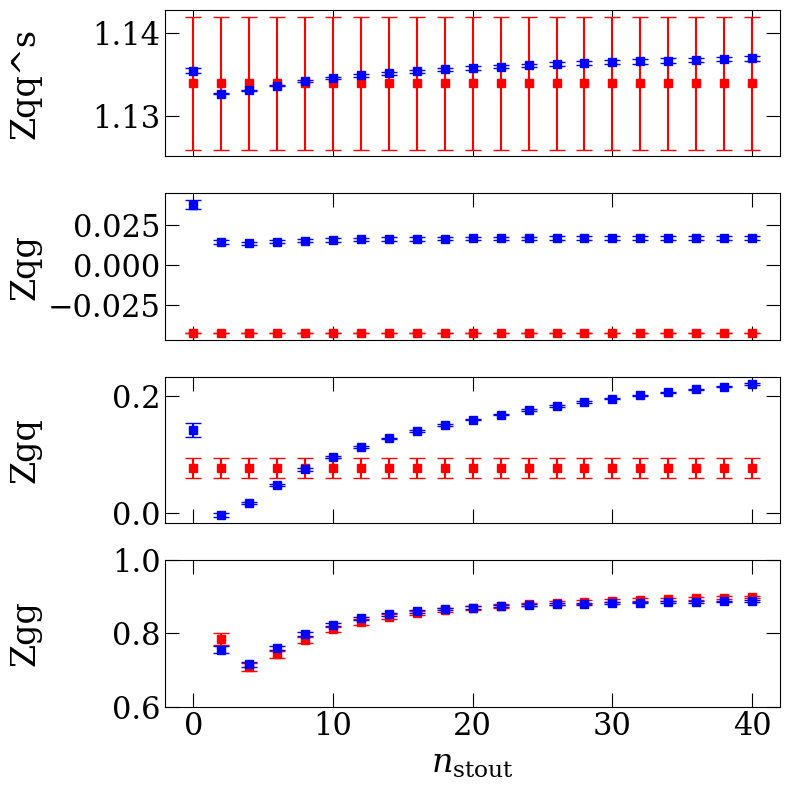

In [3]:
# preliminary non-pertubative result
enss=['b']
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    path=f'data_aux/RCs_Gregoris/ZMSbar_matrix_final_results_nd_c{ens.upper()}12.txt'
    with open(path,'r') as f:
        t=f.read().splitlines()
        for i,row in enumerate(t[1:]):
            stout,Zqqs,Zqqs_err,Zqg,Zqg_err,Zgq,Zgq_err,Zgg,Zgg_err=[float(ele) for ele in row.split('\t')]
            stout=int(stout)
            
            munu='(mu!=nu)'
            ens2RCs[ens][f'Zqq^s^{stout}{munu}']=Zqqs
            ens2RCs[ens][f'Zqq^s^{stout}{munu}_err']=Zqqs_err
            ens2RCs[ens][f'Zqg^{stout}{munu}']=Zqg
            ens2RCs[ens][f'Zqg^{stout}{munu}_err']=Zqg_err
            ens2RCs[ens][f'Zgq^{stout}{munu}']=Zgq
            ens2RCs[ens][f'Zgq^{stout}{munu}_err']=Zgq_err
            ens2RCs[ens][f'Zgg^{stout}{munu}']=Zgg
            ens2RCs[ens][f'Zgg^{stout}{munu}_err']=Zgg_err
ens2RCs_pre=ens2RCs

path='data_aux/RCs_pre.pkl'
with open(path,'wb') as f:
    pickle.dump(ens2RCs_pre,f)

ens2RCs={}
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs=pickle.load(f)
    
stouts=np.arange(0,40+1,2)
def getme(case):
    mean=[ens2RCs_pre[ens][f'{case}^{stout}{munu}'] for stout in stouts]
    err=[ens2RCs_pre[ens][f'{case}^{stout}{munu}_err'] for stout in stouts]
    m=[ens2RCs[ens][f'{case}{munu}'] if 'Zgg' not in case else ens2RCs[ens][f'{case}^{stout}{munu}'] for stout in stouts]
    e=[ens2RCs[ens][f'{case}{munu}_err'] if 'Zgg' not in case else ens2RCs[ens][f'{case}^{stout}{munu}_err'] for stout in stouts]
    return mean,err,m,e

ens='b'
fig,axs=yu.getFigAxs(4,1,sharex=True,Lrow=2,Lcol=8)
ylabels=['Zqq^s','Zqg','Zgq','Zgg']
for i,ylabel in enumerate(ylabels):
    ax=axs[i,0]
    ax.set_ylabel(ylabel)
    mean,err,m,e=getme(ylabel)
    plt_x=stouts; plt_y=m; plt_yerr=e
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
    plt_x=stouts; plt_y=mean; plt_yerr=err
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

axs[3,0].set_ylim([0.6,1])
axs[3,0].set_xlabel(r'$n_{\rm stout}$')
plt.tight_layout()
None

In [2]:
ens2RCs={}
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs=pickle.load(f)

Zs=['Zqq(mu=nu)','Zqq(mu!=nu)','Zqq^s(mu=nu)','Zqq^s(mu!=nu)','Zqg(mu=nu)','Zqg(mu!=nu)','Zgq(mu=nu)','Zgq(mu!=nu)']
precisions=[1,1,2,1,0,0,3,3]
for iZ,Z in enumerate(Zs):
    print(Z,[yu.un2str(ens2RCs[ens][Z],ens2RCs[ens][Z+'_err'],precisions[iZ]) if ens2RCs[ens][Z+'_err']!=0 else ens2RCs[ens][Z] for ens in enss])
for stout in range(5,10+1):
    Z=f'Zgg^{stout}(mu!=nu)'
    print(Z,[yu.un2str(ens2RCs[ens][Z],ens2RCs[ens][Z+'_err'],1 if ens=='b' else 2) for ens in enss])
    Z=f'Zgg^{stout}(mu=nu)'
    print(Z,[yu.un2str(ens2RCs[ens][Z],ens2RCs[ens][Z+'_err'],1 if ens=='b' else 2) for ens in enss])

Zqq(mu=nu) ['1.1167(4)', '1.1460(2)', '1.1807(2)']
Zqq(mu!=nu) ['1.1262(4)', '1.1573(3)', '1.1930(2)']
Zqq^s(mu=nu) ['1.066(29)', '1.117(26)', '1.176(15)']
Zqq^s(mu!=nu) ['1.134(8)', '1.155(8)', '1.205(5)']
Zqg(mu=nu) [-0.1169, -0.1302, -0.1451]
Zqg(mu!=nu) [-0.0424, -0.058, -0.0752]
Zgq(mu=nu) ['0.0658(206)', '0.0410(199)', '0.0139(192)']
Zgq(mu!=nu) ['0.0772(171)', '0.0521(166)', '0.0246(160)']
Zgg^5(mu!=nu) ['0.723(9)', '0.724(27)', '0.776(44)']
Zgg^5(mu=nu) ['0.73(2)', '0.710(39)', '0.765(67)']
Zgg^6(mu!=nu) ['0.743(9)', '0.756(26)', '0.799(41)']
Zgg^6(mu=nu) ['0.75(2)', '0.741(37)', '0.803(66)']
Zgg^7(mu!=nu) ['0.764(9)', '0.784(25)', '0.821(39)']
Zgg^7(mu=nu) ['0.78(1)', '0.767(36)', '0.835(64)']
Zgg^8(mu!=nu) ['0.782(8)', '0.807(25)', '0.839(37)']
Zgg^8(mu=nu) ['0.79(1)', '0.788(35)', '0.860(63)']
Zgg^9(mu!=nu) ['0.798(8)', '0.826(24)', '0.855(36)']
Zgg^9(mu=nu) ['0.81(1)', '0.805(33)', '0.880(61)']
Zgg^10(mu!=nu) ['0.811(8)', '0.841(23)', '0.867(34)']
Zgg^10(mu=nu) ['0.83(1)', 